In [7]:
from typing import Mapping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import default_collate
import matplotlib.pyplot as plt

import minai.datasets as mds

In [8]:
x_train, y_train, x_valid, y_valid, x_test, y_test = mds.load_mnist()

Using cached files in /home/nblzv/.cache/minai/datasets/MNIST/mnist.zip


In [9]:
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [208]:
def show_img(img, cmap=None):
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([]) 
    plt.imshow(img, cmap=cmap)

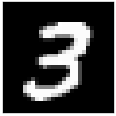

In [78]:
im3 = x_imgs[7]
plt.gcf().set_dpi(30)
show_img(im3, "gray")


In [79]:
top_edge = torch.tensor([[-1, -1, -1],
                         [0, 0, 0],
                         [1, 1, 1]]).float()

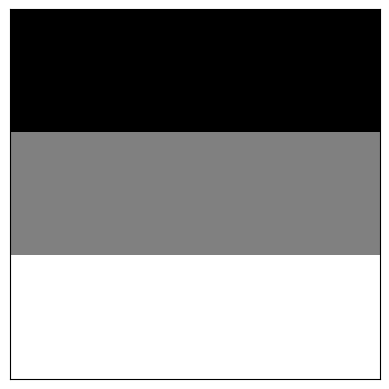

In [80]:
show_img(top_edge, "gray")

In [89]:
import pandas as pd
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{"font-size":"7pt"}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


In [93]:
temp = (im3[3:6, 14:17] * top_edge)
print(temp)
temp.sum()

tensor([[-0.0000, -0.0000, -0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.9961, 0.9883, 0.9883]])


tensor(2.9727)

In [94]:
def apply_kernel(row, col, kernel):
    temp = im3[row-1:row+2, col-1:col+2] * kernel
    return temp.sum()

In [95]:
apply_kernel(4, 15, top_edge)

tensor(2.9727)

In [103]:
locs = []
for r in range(1, im3.shape[0]-1):
    for c in range(1, im3.shape[1]-1):
        locs.append((r, c))

In [104]:
locs

[(1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (1, 15),
 (1, 16),
 (1, 17),
 (1, 18),
 (1, 19),
 (1, 20),
 (1, 21),
 (1, 22),
 (1, 23),
 (1, 24),
 (1, 25),
 (1, 26),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 22),
 (2, 23),
 (2, 24),
 (2, 25),
 (2, 26),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (3, 15),
 (3, 16),
 (3, 17),
 (3, 18),
 (3, 19),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 23),
 (3, 24),
 (3, 25),
 (3, 26),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (4, 15),
 (4, 16),
 (4, 17),
 (4, 18),
 (4, 19),
 (4, 20),
 (4, 21),
 (4, 22),
 (4, 23),
 (4, 24),
 (4, 25),
 (4, 2

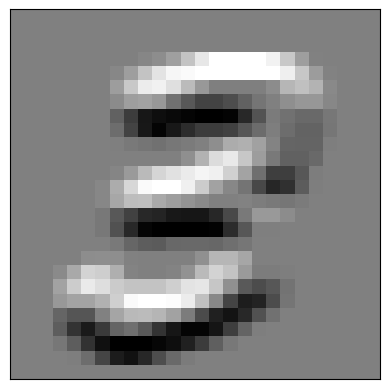

In [108]:
top_edge3 = []
for loc in locs:
    top_edge3.append(apply_kernel(loc[0], loc[1], top_edge))
top_edge3 = torch.tensor(top_edge3).view(26, 26)
show_img(top_edge3, "gray")

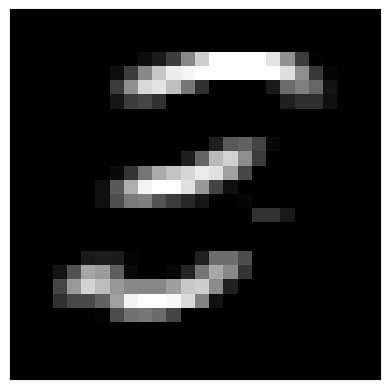

In [109]:
show_img(top_edge3.clamp_min(0), "gray")

In [145]:
left_edge = torch.tensor([[-1, 0, 1],
                          [-1, 0, 1],
                          [-1, 0, 1]]).float()

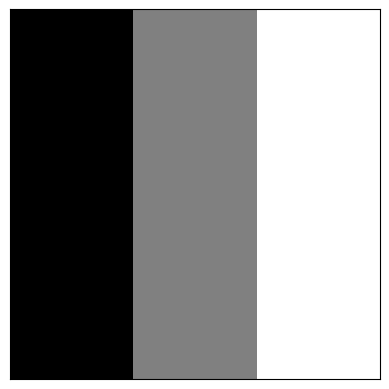

In [112]:
show_img(left_edge, "gray")

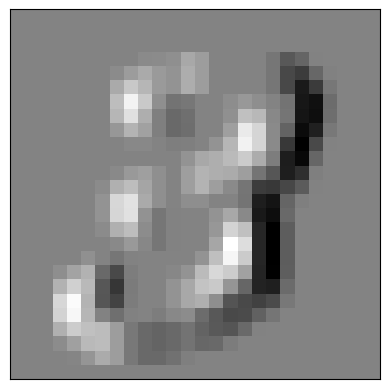

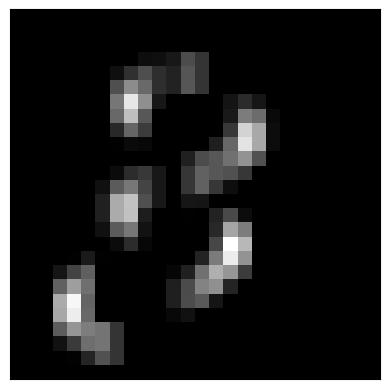

In [117]:
left_edge3 = torch.tensor([apply_kernel(loc[0], loc[1], left_edge) for loc in locs]).view(26, 26)
show_img(left_edge3, "gray")
show_img(left_edge3.clamp_min(0), "gray")

In [119]:
inp = im3[None, None, ...].float()
inp.shape

torch.Size([1, 1, 28, 28])

In [135]:
inp_unf = F.unfold(inp, (3, 3))[0].float()
inp_unf.shape

torch.Size([9, 676])

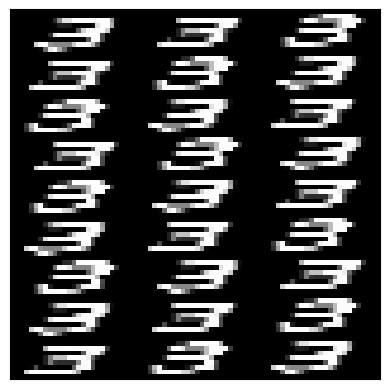

In [136]:
show_img(inp_unf.view(78, 78), "gray")

In [139]:
w = left_edge.view(-1).float()
w.shape

torch.Size([9])

In [140]:
out_unf = w@inp_unf
out_unf.shape

torch.Size([676])

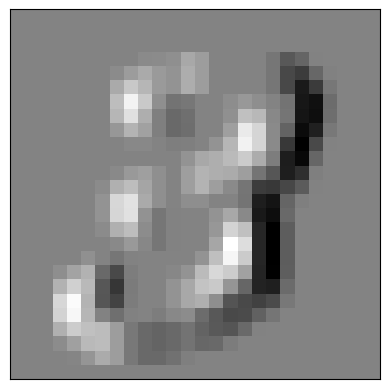

In [141]:
show_img(out_unf.view(26, 26), "gray")

In [142]:
%%timeit
torch.tensor([apply_kernel(loc[0], loc[1], top_edge) for loc in locs]).view(26, 26)

8.18 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [143]:
%%timeit
(w@F.unfold(inp, (3,3))[0]).view(26, 26)

36.8 µs ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [146]:
%%timeit
F.conv2d(inp, left_edge[None, None, ...])

23.1 µs ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [151]:
diag1_edge = torch.tensor([[0, 1, -1],
                           [1, -1, 0],
                           [-1, 0, 0]]).float()

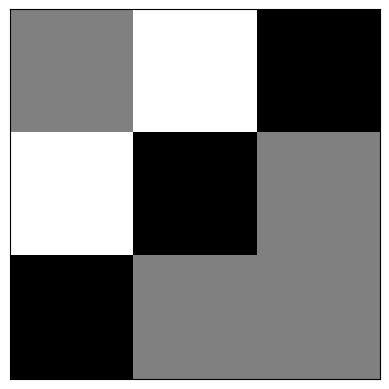

In [152]:
show_img(diag1_edge, "gray")

In [156]:
diag2_edge = torch.tensor([[-1, 1, 0],
                           [0, -1, 1],
                           [0, 0, -1]]).float()

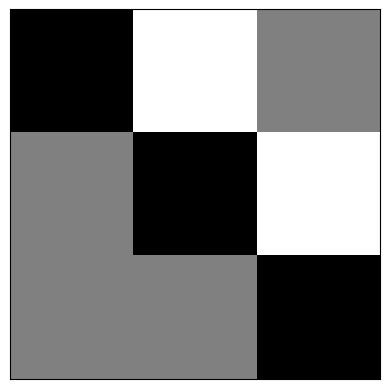

In [157]:
show_img(diag2_edge, "gray")

In [161]:
xb = x_imgs[:16][:, None, ...]
xb.shape

torch.Size([16, 1, 28, 28])

In [162]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:, None, ...]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [163]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 4, 26, 26])

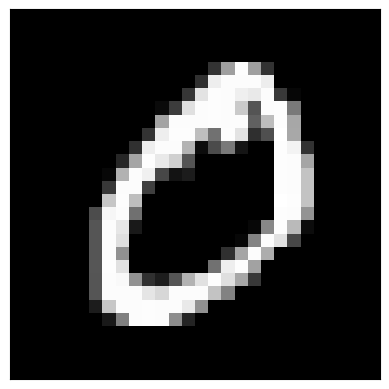

In [166]:
img0 = xb[1, 0]
show_img(img0, "gray")

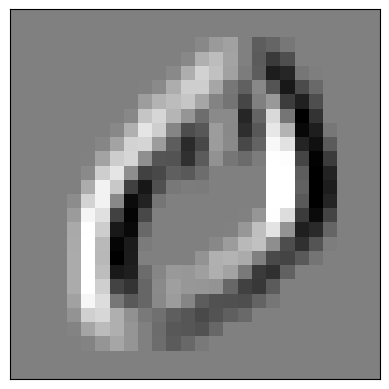

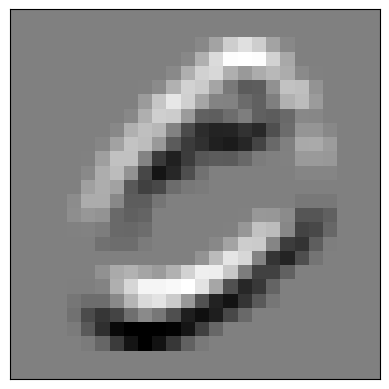

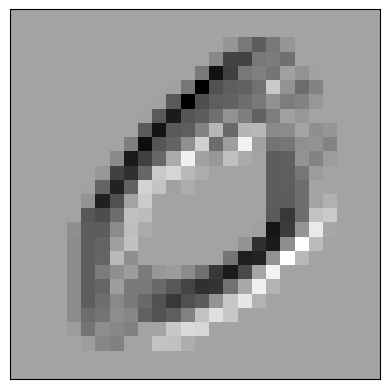

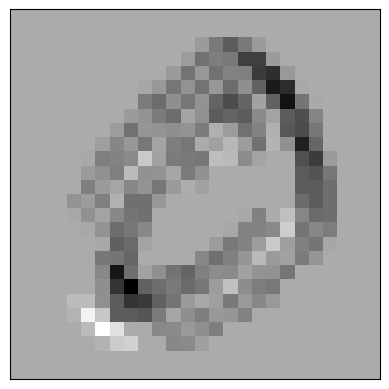

In [168]:
for i in range(4):
    show_img(batch_features[1, i], "gray")

In [169]:
n, m = x_train.shape
c = y_train.max() + 1
nh = 50

In [170]:
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [171]:
broken_cnn = nn.Sequential(nn.Conv2d(1, 30, 3, 1, 1),
                           nn.ReLU(),
                           nn.Conv2d(30, 10, 3, 1, 1))

In [172]:
broken_cnn(xb).shape

torch.Size([16, 10, 28, 28])

In [173]:
def conv(inp, out, ks=3, stride=2, act=True):
    res = nn.Conv2d(inp, out, ks, stride, ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [181]:
simple_cnn = nn.Sequential(conv(1, 4),
                           conv(4, 8),
                           conv(8, 16),
                           conv(16, 16),
                           conv(16, 10, act=False),
                           nn.Flatten())

In [182]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [183]:
class Dataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [184]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)
train_ds = Dataset(x_imgs, y_train)
valid_ds = Dataset(xv_imgs, y_valid)

In [185]:
def_device = "cuda"

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k: v.to(device) for k, v in x.items()}
    return type(x)(to_device(o, device) for o in  x)

def collate_device(b): return to_device(default_collate(b))

In [186]:
from torch.utils.data import DataLoader

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=2*bs, shuffle=False, **kwargs))

In [187]:
from torch import optim

bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [192]:
def accuracy(preds, yb): 
    return (preds.argmax(1) == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss = tot_acc = count = 0
            for xb, yb in valid_dl:
                preds = model(xb)

                count += n
                tot_loss += loss_func(preds, yb).item()*n
                tot_acc += accuracy(preds, yb).item()*n
            print(epoch, tot_loss/count, tot_acc/count)

    return tot_loss/count, tot_acc/count

In [193]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.40600401610136033 0.8703469663858414
1 0.2518054470419884 0.9244600176811218
2 0.14673920758068562 0.9546300560235977
3 0.1983179122209549 0.9433536320924759
4 0.10788623169064522 0.9698299646377564


(0.10788623169064522, 0.9698299646377564)

In [194]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08406053883954882 0.9745806515216827
1 0.08324094843119383 0.9746897965669632
2 0.08210871927440166 0.9758616715669632
3 0.08539256155490875 0.9747874528169632
4 0.08051562085747718 0.9760225176811218


In [196]:
simple_cnn[0][0]

Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [199]:
conv1 = simple_cnn[0][0]
conv1.weight.shape

torch.Size([4, 1, 3, 3])

In [200]:
from torchvision.io import read_image

In [203]:
im = read_image("images/grizzly.jpg")
im.shape

torch.Size([3, 1000, 846])

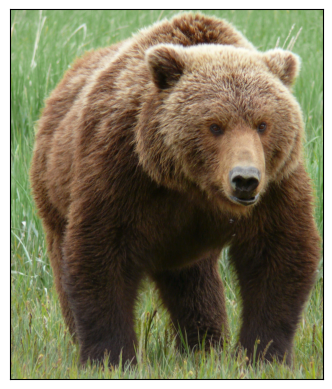

In [205]:
c, h, w = range(3)
show_img(im.permute(h, w, c))

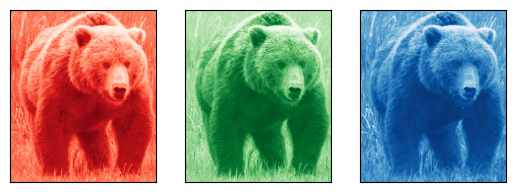

In [209]:
_, axs = plt.subplots(1, 3)
for bear, ax, color in zip(im, axs, ["Reds", "Greens", "Blues"]):
    plt.sca(ax)
    show_img(255-bear, color)